In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
IMG_WIDTH = 196
IMG_HEIGHT = 64
BATCH_SIZE = 32
EPOCHS = 30  # Reduce epochs since we're fine-tuning a pretrained model

# Dataset Paths
DATASET_PATH = "/kaggle/input/manuscripts-language-classification/dataset/manuscript_words"

# ImageDataGenerator for training & validation
char_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

char_train_gen = char_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resizing images
    batch_size=BATCH_SIZE,
    color_mode='grayscale',  # Grayscale images
    class_mode='categorical',
    subset='training'
)

char_val_gen = char_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

print("Character Dataset Details:")
print(f"Total Training Samples: {char_train_gen.samples}")
print(f"Total Validation Samples: {char_val_gen.samples}")
print(f"Class Labels: {char_train_gen.class_indices}")


Found 197327 images belonging to 2 classes.
Found 49331 images belonging to 2 classes.
Character Dataset Details:
Total Training Samples: 197327
Total Validation Samples: 49331
Class Labels: {'sanskrit_words': 0, 'tamil_words': 1}


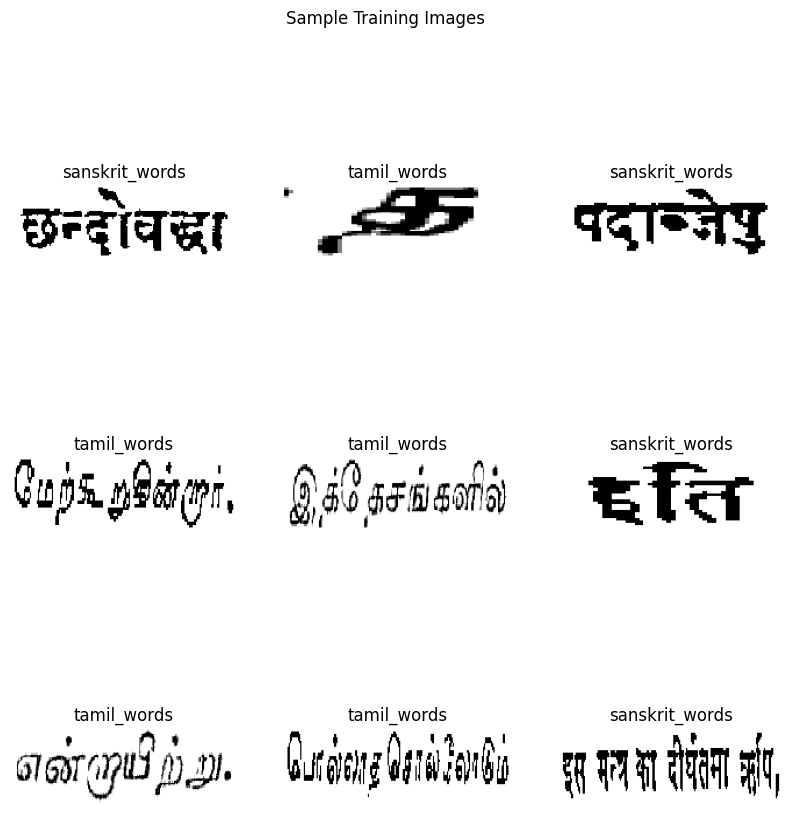

In [3]:

# Get a batch of images and labels from the training generator
sample_images, sample_labels = next(char_train_gen)

# Get class labels
class_labels = list(char_train_gen.class_indices.keys())

# Plot sample images
plt.figure(figsize=(10, 10))
for i in range(9):  # Plot 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')  # Show grayscale image
    label_index = np.argmax(sample_labels[i])  # Get class index
    plt.title(class_labels[label_index])  # Get class name
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.show()


In [4]:
from tensorflow.keras.utils import plot_model

# Plot the model

char_model = models.Sequential([
    layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),  # Replaces Flatten()
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(2, activation='softmax')  # 2 classes: Tamil, Sanskrit
])

# Compile Model
char_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Callbacks: Early Stopping + Learning Rate Reduction
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]
plot_model(char_model, to_file='char_model_architecture.png', show_shapes=True, show_layer_names=True)


# Train Model
history_char = char_model.fit(
    char_train_gen,
    validation_data=char_val_gen,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

# Save Model
char_model.save("improved_cnn_character_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6166/6167 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9809 - loss: 0.0553
Epoch 1: val_loss improved from inf to 0.04614, saving model to best_model.keras
6167/6167 ━━━━━━━━━━━━━━━━━━━━ 880s 141ms/step - accuracy: 0.9809 - loss: 0.0553 - val_accuracy: 0.9802 - val_loss: 0.0461 - learning_rate: 0.0010
Epoch 2/30
6166/6167 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9942 - loss: 0.0165
Epoch 2: val_loss improved from 0.04614 to 0.03647, saving model to best_model.keras
6167/6167 ━━━━━━━━━━━━━━━━━━━━ 479s 78ms/step - accuracy: 0.9942 - loss: 0.0165 - val_accuracy: 0.9895 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 3/30
6166/6167 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9960 - loss: 0.0113
Epoch 3: val_loss did not improve from 0.03647
6167/6167 ━━━━━━━━━━━━━━━━━━━━ 494s 80ms/step - accuracy: 0.9960 - loss: 0.0113 - val_accuracy: 0.9610 - val_loss: 0.0999 - learning_rate: 0.0010
Epoch 4/30
6166/6167 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9968 - loss: 0.0082
Ep

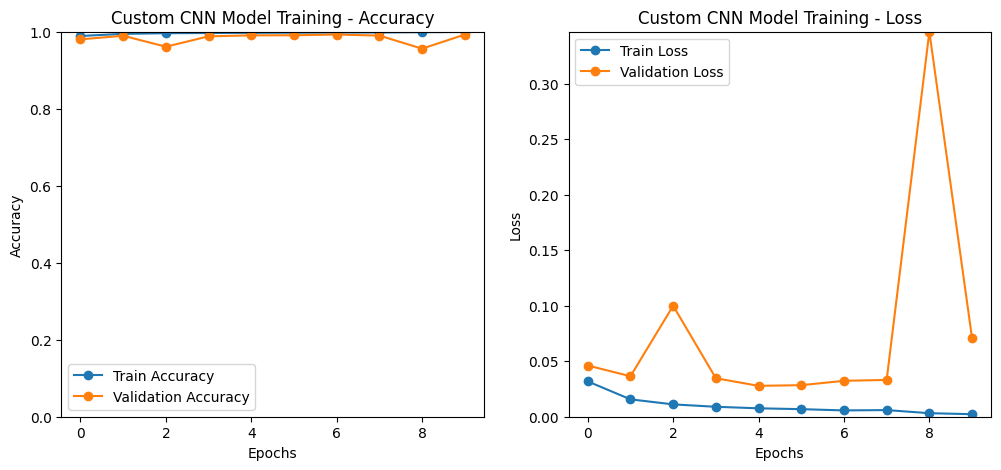

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

Classification Report:
                precision    recall  f1-score   support

sanskrit_words       0.98      1.00      0.99     24079
   tamil_words       1.00      0.99      0.99     25252

      accuracy                           0.99     49331
     macro avg       0.99      0.99      0.99     49331
  weighted avg       0.99      0.99      0.99     49331



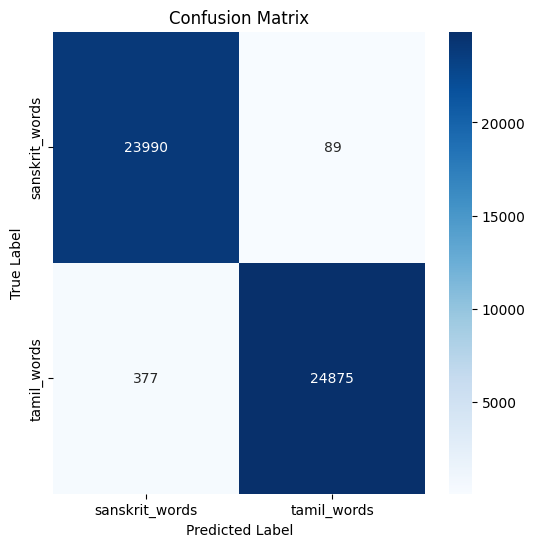

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


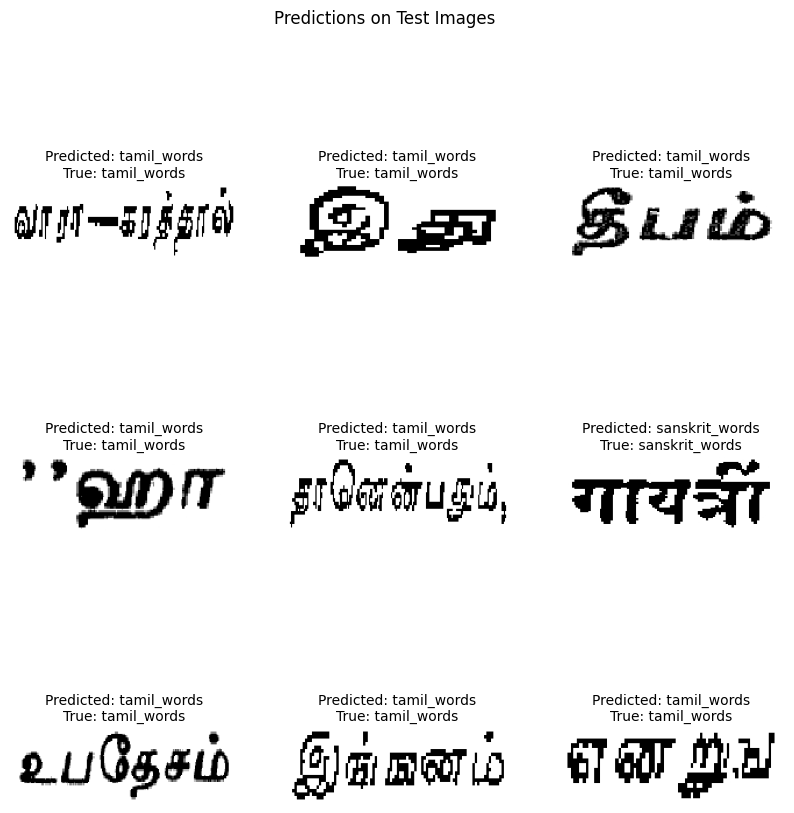

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ------------------ Function to Plot Accuracy & Loss ------------------
def plot_training(history, title="Training Progress"):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  # Set y-axis to start from 1
    plt.legend()
    plt.title(f"{title} - Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Dynamic y-axis for loss
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.show()

plot_training(history_char, "Custom CNN Model Training")

# ------------------ Classification Report & Confusion Matrix ------------------
# Get true labels & predictions
y_true = []
y_pred = []


# Get class labels
classes = list(char_train_gen.class_indices.keys())

# Get all validation data in one go
val_images, val_labels = zip(*(char_val_gen[i] for i in range(len(char_val_gen))))

# Convert to numpy arrays
val_images = np.vstack(val_images)  # Stack all images
val_labels = np.vstack(val_labels)  # Stack all labels

# Get predictions for the entire validation set at once
preds = char_model.predict(val_images)

# Convert one-hot labels & predictions to class indices
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(preds, axis=1)

# Classification Report (Accuracy, Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ------------------ Test Predictions ------------------
def plot_test_images_with_predictions(model, test_generator, num_images=9):
    test_images, true_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(test_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')  # Show as grayscale
        plt.title(f'Predicted: {predicted_labels[i]}\nTrue: {classes[np.argmax(true_labels[i])]}', fontsize=10)
        plt.axis('off')

    plt.suptitle("Predictions on Test Images")
    plt.show()

plot_test_images_with_predictions(char_model, char_val_gen, num_images=9)
